Please run the cell below to ensure that the rest of the report goes as expected!

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(ggplot2)
library(RColorBrewer)
library(kknn)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

---

# From Sessions to Predictions: Modeling Engagement with KNN Regression

---

## Introduction

From the title you're probably wondering, what are 'sessions,' what is being predicted, and most likely what even is the term 'KNN Regression.' Well no need to worry! Our project stems from a UBC Computer Science study called **PLAIcraft** with the goal and I quote, "PLAICraft is a research data collection project with the aim of enabling advanced embodied AI research." - PLAIcraft Frequently Asked Questions. They have tasked us with helping them out by answering a few questions for them based on two anonymised datasets regarding player data, and individual play session data. This leads to the question which we attempted to answer for them!

### Our Question

**Can we predict the number of future sessions a player will engage in based on their initial session characteristics and player information?**

To simplify that down more, what our goal was for this data analysis was to utilize a players specific data, as well as the session data for only their very first session to determine if they will return for subsequent sessions, and if they do, how many? 

### The Dataset

Now for the bread and butter, well perhaps the dataset is the bread and the data analysis that comes later is the butter, who knows. Through this brief section we will load the data and talk about it and most importantly help you to understand what all of it means before we get into the next section which is where the real fun begins.

In [2]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


Alright, so what we've done is loaded both datasets and then directly above this is a sneak-peek at the player information dataset! A lot of the data here is pretty obvious such as **name**, **gender**, and **age**. The other columns of data represent somewhat less obvious data such as the **experience** column denoting the players self-identified minecraft skill level which they can choose as Pro, Amateur, Regular, and more. To the right of that is the **subscribe** which shows whether or not they enrolled in the email list of the study. Look right once more and we see the **hashedEmail** column which is an anonymised encoding of each users email (this comes in handy later on), and finally is the **played_hours** data which represents each users *total* hours played on the server. As we are not cleaning up the data yet, the individualId and organizationName columns are still visible but they contain no data so when we move on later we will take care of that.

In [4]:
head(sessions)

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


Now we're looking at the combined players sessions dataset which includes session data for the sessions of all the players in the study. Again, this is only a sneak-peek into it, when in reality it has over three thousand rows. We still see **hashedEmail** in this dataset, but the rest of the variables are different! The **start_time** and **end_time** columns represent the corresponding date and time in which each play-session was initiated and terminated. The **original_start_time** and **original_end_time** columns are a bit more complicated, but they are just the UNIX timestamp versions of the other start and end time columns, so don't worry about them!

---

## Methods and Results

### Data Wrangling

As mentioned in the introductory section, we noted some issues with the current data such as the **individualId** and **organizationName** columns not being populated with any data, and the **original_start_time** and **original_end_time** columns being rendered redundant by the existence of the much easier to work with **start_time** and **end_time** columns.

To fix these and make our data *tidy*, we will modify the current dataframes to do so by selecting which columns we would like to exclude by using subset and select! - starting with the players **players** dataframe:

In [5]:
players <- subset(players, select = -c(individualId, organizationName))
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


That's looking much tidier already! Let's do the **sessions** dataframe next:

In [6]:
sessions <- subset(sessions, select = -c(original_start_time, original_end_time))
head(sessions)

hashedEmail,start_time,end_time
<chr>,<chr>,<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10


There's one sneaky thing that may trip us up later if not fixed. We can see that the **start_time** and **end_time** columns are of type *chr (character)* which may make working with them a bit tedious. To resolve this we will employ the **asPOSIXct** function from the base R library to convert them to the type *dttm (date time month)* which will make them far easier to use.

In [7]:
sessions <- mutate(sessions, start_time = as.POSIXct(start_time, format="%d/%m/%Y %H:%M", tz="PST"),
         end_time = as.POSIXct(end_time, format="%d/%m/%Y %H:%M", tz="PST"))

head(sessions)

hashedEmail,start_time,end_time
<chr>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00


Now we can use those columns to do something that will be very important to our analysis which is computing the duration of the sessions (difference between start_time and end_time in minutes)!

In [8]:
sessions <- mutate(sessions, session_duration = as.numeric(difftime(end_time, start_time, units = "mins")))

head(sessions)

hashedEmail,start_time,end_time,session_duration
<chr>,<dttm>,<dttm>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,11
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,122


Both of our dataframes look very tidy now, although working with two separate dataframes may overcomplicate our analysis and code both for us to work with and for you to understand. While we are doing that, we will also manipulate the data to introduce two new columns of further useful metrics regarding our analysis. Since we're basing our predictions off of every players first session, we really want to know their first session length: **first_session_duration** and how many sessions they return to play after that one: **future_sessions_played**.

In [9]:
player_session_combined <- players |> inner_join(sessions, by = "hashedEmail")

player_session_finalized <- player_session_combined |>
  group_by(hashedEmail) |>
  mutate(first_session_duration = first(session_duration),
         future_sessions_count = n() - 1) |>
  ungroup()

head(player_session_finalized)

experience,subscribe,hashedEmail,played_hours,name,gender,age,start_time,end_time,session_duration,first_session_duration,future_sessions_count
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 00:21:00,2024-08-08 01:35:00,74,74,26
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-09 22:30:00,2024-09-09 22:37:00,7,74,26
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 02:41:00,2024-08-08 03:25:00,44,74,26
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-10 15:07:00,2024-09-10 15:29:00,22,74,26
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-05-05 22:21:00,2024-05-05 23:17:00,56,74,26
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-04-06 22:24:00,2024-04-06 23:33:00,69,74,26


One crucial thing we must do prior to moving on is to remove every row for each hashedEmail **except** the session which occurs, and while we do that we may as well remove all the other columns which will be not applicable to our analysis such as the **start_time** and **end_time** columns, as well as individual session durations, players names, and their hashed emails. This is to cut any fluff that would mess with our analysis as only certain variables will be used as predictors!

In [10]:
final_wrangled_data <- player_session_finalized |>
  group_by(hashedEmail) |>
  filter(start_time == min(start_time)) |> 
  ungroup() |>
  select(age, gender, subscribe, experience, first_session_duration, future_sessions_count)   

head(final_wrangled_data)

age,gender,subscribe,experience,first_session_duration,future_sessions_count
<dbl>,<chr>,<lgl>,<chr>,<dbl>,<dbl>
9,Male,TRUE,Pro,74,26
17,Male,TRUE,Veteran,12,2
17,Male,FALSE,Veteran,5,0
21,Female,TRUE,Amateur,50,0
21,Male,TRUE,Regular,9,0
21,Male,FALSE,Amateur,5,0


One quick thing we learned during our analysis was that there were about 7 rows which held very high future session counts (approximately 50 more than the rest) which skewed our model heavily. We collectively chose to remove those five entries which benefitted our model heavily as will be seen later in the analysis portion. Below this is what we used to make this fix, and while we were at it we made sure to drop any **NA** data rows as well:

In [11]:
# Removing any rows with NA data
final_wrangled_data <- drop_na(final_wrangled_data)

# Removing those seven or so data entry outliers so as not to skew our data
final_wrangled_data <- final_wrangled_data |>
  filter(future_sessions_count <= 50)

![](data/wrangled.jpg)

We agree with the cowboy on this one, that data is looking very wrangled and ready to be analyzed, so let's do it!

---

## Some Thoughts About the Data

---

Now that we've manipulated and cut down our two data sets into just one dataframe that possesses only the variables relevant for our analysis, it's a good time to make sure we know what we're working with, and also to spot some possibly useful trends. To start, we'll provide a quick summary of our variables we'll be using in the analysis as well as why:

- **final_wrangled_data**:
  - `age`: Denotes the self-identified age of the player and will be used to determine if older/younger players return more frequently
  - `gender`: Denotes the self-identified gener of the player and will also be used to determine if gender plays a role in return session frequency
  - `subscribe`: Identifies whether or not the player has subscribed to PLAIcraft's email list, we predict that if they are subscribed they are likely more interested and thus more likely to return for more sessions
  - `experience`: Denotes the self-identified Minecraft experience level of the player, will also be used to see if a more experienced user comes back more often or if newer players get hooked and return more, or even both
  - `first_session_duration`: Represents how long the players first play session on the study was. A longer initial session may indicate more interest
  - `future_sessions_count`: Represents how many times the player returns to play on the study's server, will be useful in training our model so it can predict better

Now that you understand the variables we'll be using for our analysis, it may help to actually 'see' the dataset we'll be using because we acknowledge dataframes will only help so much for understanding. An interesting

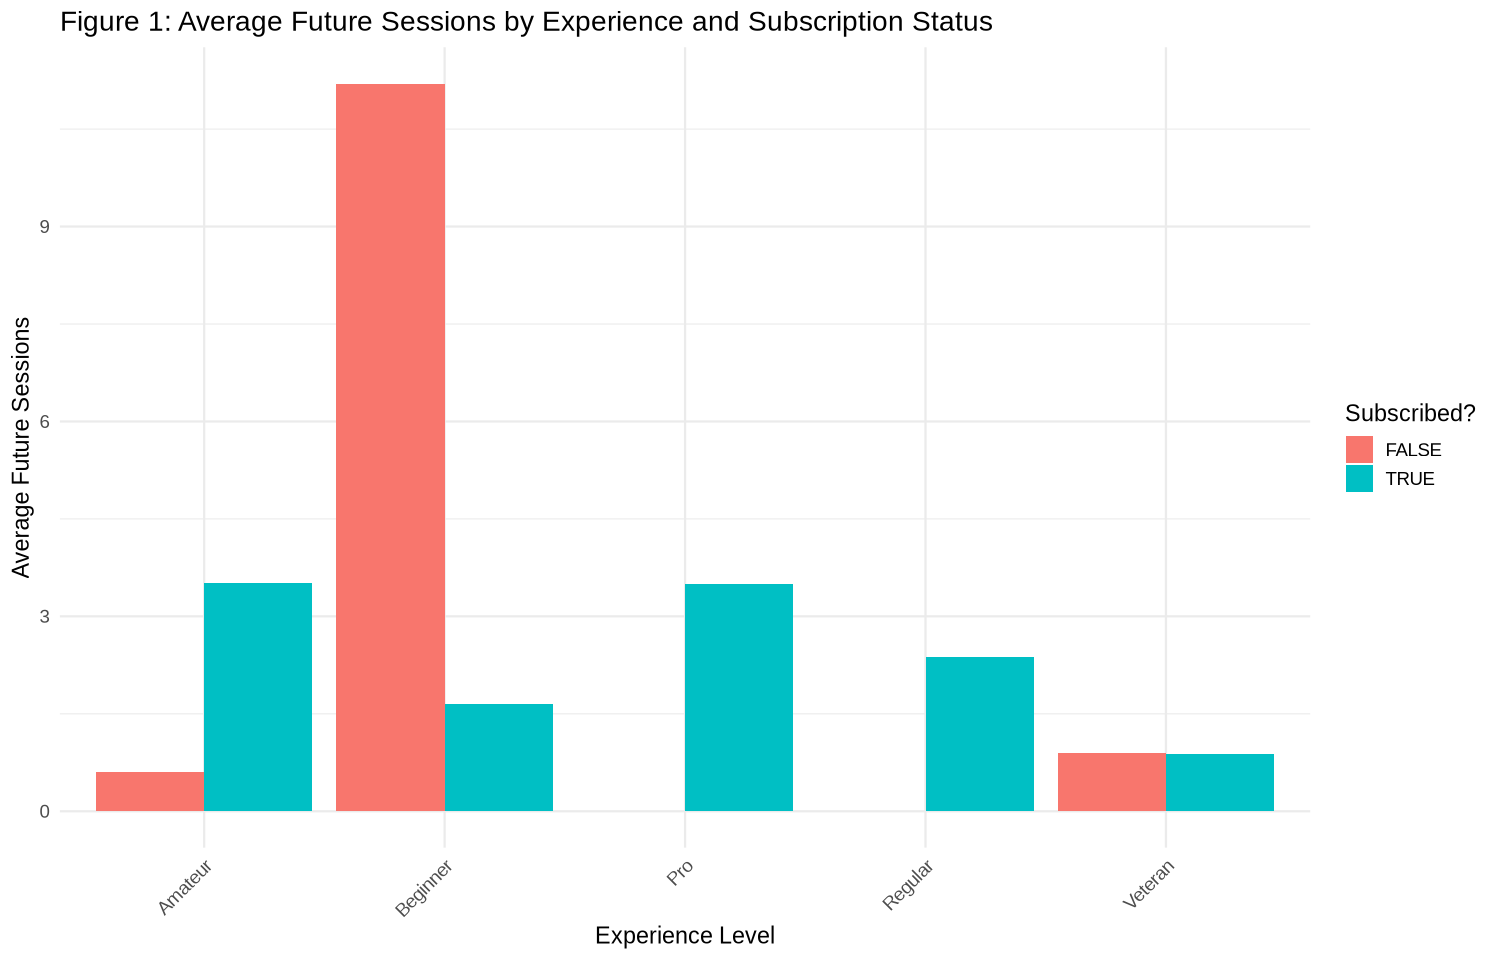

In [12]:
options(repr.plot.height = 8, repr.plot.width = 12.5)

subscription_status_engagement_plot <- final_wrangled_data |> 
  ggplot(aes(x = experience, y = future_sessions_count, fill = subscribe)) +
      stat_summary(fun = "mean", geom = "bar", position = "dodge") +
      labs(title = "Figure 1: Average Future Sessions by Experience and Subscription Status",
      x = "Experience Level", y = "Average Future Sessions", fill = "Subscribed?") +
      theme_minimal(base_size = 14) +
      theme(legend.position = "right", axis.text.x = element_text(angle = 45, hjust = 1))

subscription_status_engagement_plot

The plot above (Figure 1) visualizes something we already predicted which was a relationship between a players subscription status indicating their possible ongoing interest. From the plot we can clearly see that the two biggest spikes in average future sessions are classified as true in the subscription data category. This makes sense as users who are likely to bother to sign up for the emails are also likely the ones to contribute more data to the study. The one point of note in this plot is the discrepancy in this assumption for the *beginner* experience level. This can most likely be attributed to the fact that beginners probably have no Minecraft experience and are unsure if they will enjoy it so don't sign up for emails, but then end up getting intrigued by it and keep coming back!

## Data Analysis

Now that the data is prepped and ready to go as well as some connections within the dataset being made, we can move on to finally working to answer our question. One important thing we must do first is since we intend on using the **experience** and **subscribe** data in our prediction model we are unable to keep them as their current type of character. To resolve this, we will convert the subscribe column into 0's representing false (or unsubscribed), and 1's representing true (subscribed). We will repeat this with the experience column but instead having each experience level starting from beginner up to pro classified as 0 through 4.

In [13]:
final_wrangled_data$subscribe <- as.numeric(final_wrangled_data$subscribe)

experience_levels <- c("Beginner" = 0, "Amateur" = 1, "Regular" = 2, "Veteran" = 3, "Pro" = 4)

final_wrangled_data$experience <- as.numeric(experience_levels[final_wrangled_data$experience])

head(final_wrangled_data)

age,gender,subscribe,experience,first_session_duration,future_sessions_count
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
9,Male,1,4,74,26
17,Male,1,3,12,2
17,Male,0,3,5,0
21,Female,1,1,50,0
21,Male,1,2,9,0
21,Male,0,1,5,0


Age and gender will simply remain as they are since we will not be using them in our prediction model, but afterwards when we analyse the results to help spot any age or gender based trends! Now we will begin to build our model starting by splitting our data up and then to ensure our data doesn't cause any unexpected issues, we will remove any rows with **NA** data from both the training and testing sets.

In [14]:
# To ensure our results are reproducible for now
set.seed(5)

# Putting in a 75% training/testing split, may change later depending on performance
plaicraft_split <- initial_split(final_wrangled_data, prop = 0.75, strata = future_sessions_count)
plaicraft_train <- training(plaicraft_split) 
plaicraft_test <- testing(plaicraft_split)

plaicraft_train <- drop_na(plaicraft_train)
plaicraft_test <- drop_na(plaicraft_test)

Alright, now that we have our data split up and stratified to our target predictor we will get our models recipe and specification. Since we are using multiple predictors (**experience, subscribe, and first_session_duration**) we must scale and center our predictors as well. Then as usual we will specify our model to use KNN Regression!

In [15]:
plaicraft_recipe <- recipe(future_sessions_count ~ first_session_duration + subscribe + experience, data = plaicraft_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

plaicraft_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |> set_engine("kknn") |> set_mode("regression")

Now since the provided dataset is on the smaller side, we chose to employ cross-validation so we could give the model more experience by training it on more subsets of our dataset. Specifically for our case we are using 4-fold cross validation and keeping the stratified variable the same. (we chose 4 fold because of our data dimensions as 5-fold was returning a size-related mismatch error)

In [16]:
plaicraft_vfold <- vfold_cv(plaicraft_train, v = 4, strata = future_sessions_count)

It's now time to put our specification and recipe into our workflow:

In [17]:
plaicraft_wkflw <- workflow() |>
  add_recipe(plaicraft_recipe) |>
  add_model(plaicraft_spec)

plaicraft_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


That looks pretty good to us. Since our dataset is small, we will only run our cross-validation for a grid of numbers for neighbors ranging from **$K = 1$** neighbors up to $K = 30$ neighbors. We predict that the $K = 1$ neighbor will have worse performance due to the inherent overfitting that will occur, so this will help us to determine the optimal value to use for our model.

In [18]:
gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

plaicraft_results <- plaicraft_wkflw |>
  tune_grid(resamples = plaicraft_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

plaicraft_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,13.165979,4,1.1812737,Preprocessor1_Model01
2,rmse,standard,10.061962,4,0.9771048,Preprocessor1_Model02
3,rmse,standard,9.326214,4,1.5897068,Preprocessor1_Model03
4,rmse,standard,8.775867,4,1.5433174,Preprocessor1_Model04
5,rmse,standard,8.578520,4,1.6516928,Preprocessor1_Model05
6,rmse,standard,8.716003,4,1.4831746,Preprocessor1_Model06
7,rmse,standard,8.341270,4,1.6744072,Preprocessor1_Model07
8,rmse,standard,8.360054,4,1.7026888,Preprocessor1_Model08
9,rmse,standard,8.301414,4,1.7534404,Preprocessor1_Model09


And now we'll grab the row which has the lowest RMSE to determine which $K$ we will use:

In [19]:
plaicraft_min <- plaicraft_results |>
  filter(mean == min(mean))

plaicraft_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,rmse,standard,8.013663,4,1.766029,Preprocessor1_Model16


It looks like $K = 30$ neighbors is the sweet spot of where our model performs the best, although that was all done on the training set of the data. Now it's time for the fun part of seeing how our model performs on the testing portion of the data with our 'best' $K$-value. We will start by re-training the model using $K = 30$:

In [20]:
kmin <- plaicraft_min |> pull(neighbors)

plaicraft_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

plaicraft_fit <- workflow() |>
  add_recipe(plaicraft_recipe) |>
  add_model(plaicraft_spec) |>
  fit(data = plaicraft_train)

All that we have to do now is predict our testing data with it and then get the RMSE value to see how it really performs:

In [21]:
plaicraft_summary <- plaicraft_fit |>
  predict(plaicraft_test) |>
  bind_cols(plaicraft_test) |>
  metrics(truth = future_sessions_count, estimate = .pred) |>
  filter(.metric == 'rmse')

plaicraft_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.847696


Compared to our results on the training data, this RMSPE is actually great (improvement wise that is)! We won't discuss it much in this section as we'll leave that until the summary portion, but what we will do is visualize what this result represents!

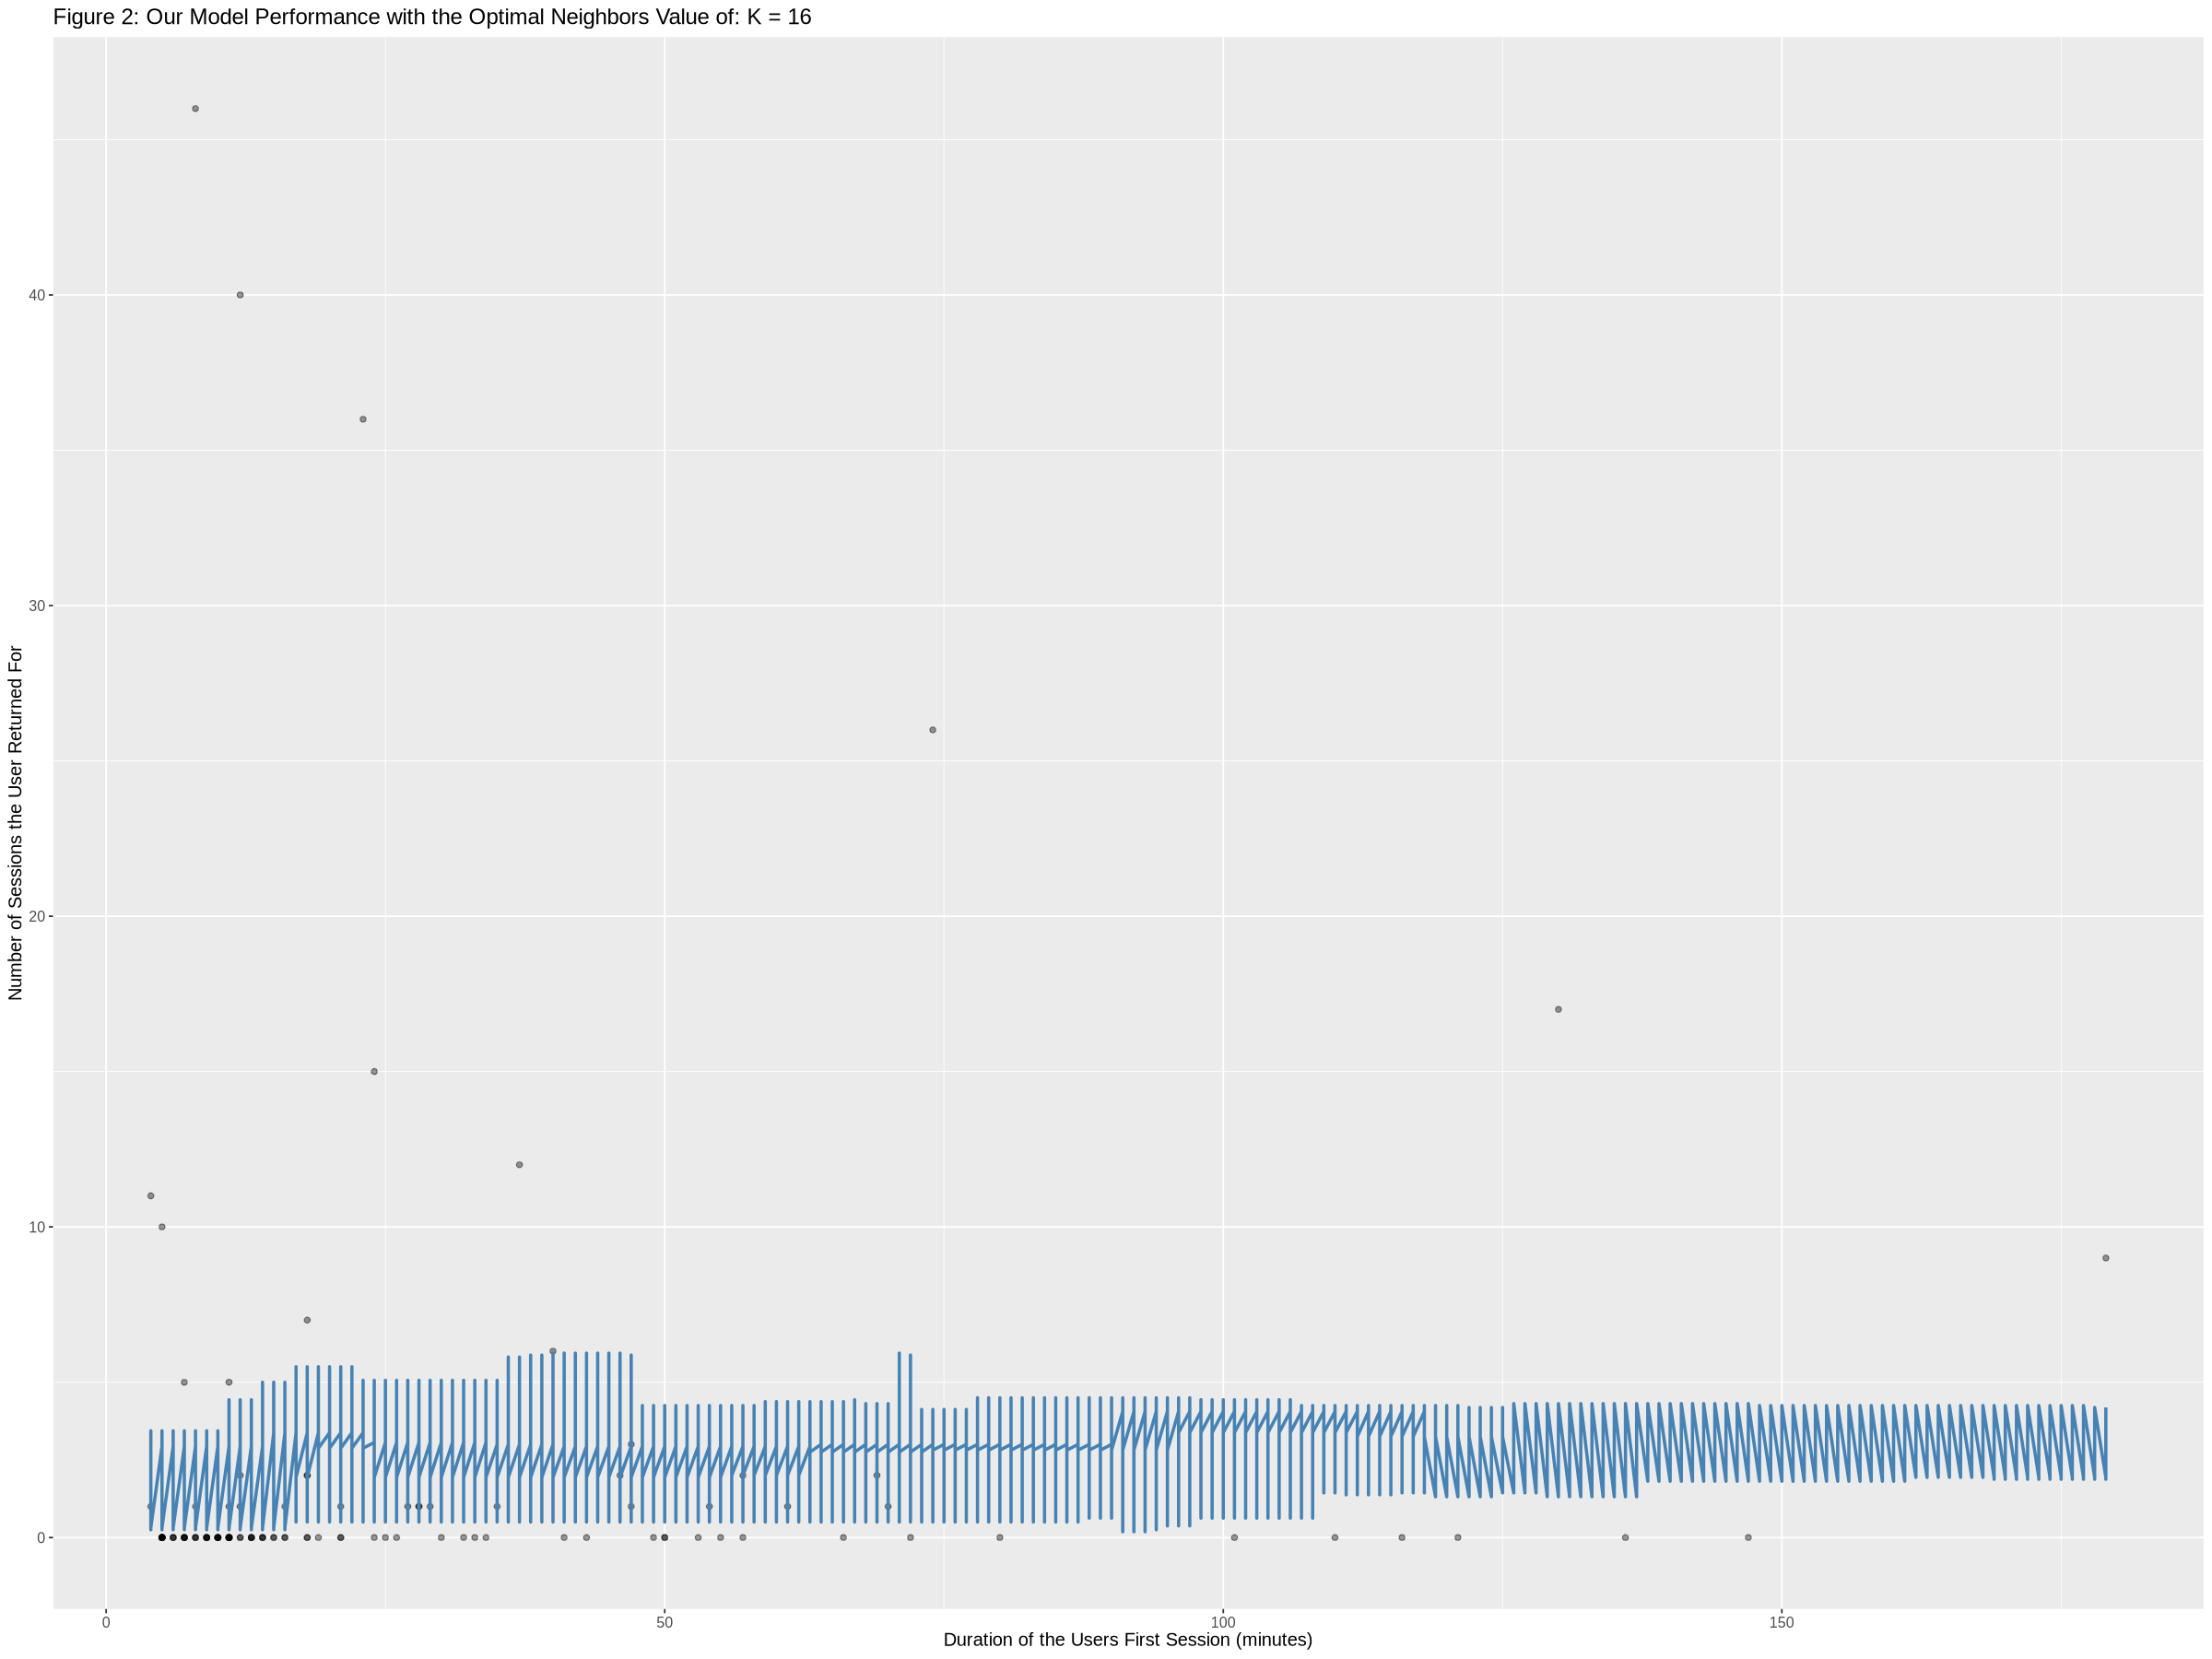

In [22]:
options(repr.plot.width = 2, repr.plot.height = 15)

future_sessions_prediction_grid <- expand_grid(
    first_session_duration = seq(
        from = final_wrangled_data |> pull(first_session_duration) |> min(),
        to = final_wrangled_data |> pull(first_session_duration) |> max(), by = 1), 
        subscribe = c(0, 1), experience = 0:4)

plaicraft_preds <- plaicraft_fit |>
  predict(future_sessions_prediction_grid) |>
  bind_cols(future_sessions_prediction_grid)

plot_final <- ggplot(final_wrangled_data, aes(x = first_session_duration, y = future_sessions_count)) +
  geom_point(alpha = 0.4) +
  geom_line(data = plaicraft_preds,
            mapping = aes(x = first_session_duration, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Duration of the Users First Session (minutes)") +
  ylab("Number of Sessions the User Returned For") +
  ggtitle(paste0("Figure 2: Our Model Performance with the Optimal Neighbors Value of: K = ", kmin)) +
  theme(text = element_text(size = 12))

plot_final

The plot above shows our models predictions (the blue line) compared to the data. As we mentioned earlier, we removed about 7 outlier data points which were greater than 50 future sessions because those few data points would pull our prediction model high above the majority of the other points and thus we had about 7 data points that raised our entire models error margin by about 30 sessions. This choice of ours dropped the error margin to about 3 sessions which is a great improvement.

---

## Data Analysis Discussion

---

**Summary**


The data analysis highlighted a strong relationship between characteristics present in a users initial session `first_session_duration` and `future_sessions_count`. Although this relationship is strong, we see that longer initial sessions do not directly lead to a increase in the number of sessions a user returned for. By using a 75/25 split for the training and testing data, we were able to minimize the overall RMSE value and in turn, improve the accuracy of our regression model. Additionally, we see that the users who have decided to subscribe with their emails generally have a higher rate of returning (more sessions on average) than a user that does not. Based on our overall data analysis, we can conclude that users will return anywhere between 2 to 5 sessions after their initial session, with subscribing users falling near the higher end of that range.

These findings can be an indicator of how attractive playing Minecraft for free online is. Since many users return more than once, it can be said that being able to play a paid game for free is still enticing to many individuals despite the limitations that PLAIcraft may have.


**Questions**

1. How would using a different regression model (i.e. linear regression) alter our final results?

2. Does the time of the day have an effect on how long a player is willing to play for?

3. What can be done in order for already-subscribed players to return more often?